# Helpful Function

You will see these at the top of every module.  These are simply a set of reusable functions that we will make use of.  Each of them will be explained as the semester progresses.  They are explained in greater detail as the course progresses.  Class 4 contains a complete overview of these functions.

In [1]:
import base64
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing


# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = f"{name}-{tv}"
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name ,main=None):
    newOutcome = []
    if main is not None:
        for other in df[name]:
            if other != main:
                newOutcome.append("other")
            else:
                newOutcome.append(main)
        df[name] = newOutcome
    #print(df[name][490950:491050])           
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(
        target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    # Regression
    return df[result].values.astype(np.float32), df[[target]].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean())
                          >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low

# The KDD-99 Dataset

The KDD-99 dataset is very famous in the security field and almost a "hello world" of intrusion detection systems in machine learning.

# Read in Raw KDD-99 Dataset

In [2]:
from keras.utils.data_utils import get_file
import pandas as pd

# This file is a CSV, just no CSV extension or headers
# Download from: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

#C:\\Users\\user\\Documents\\GitHub\\N.T.T.D-with-M.L\\Traning set\\KDD-99\\kddcup.data_10_percent_corrected
#D:\\training set\\kdd data set\\kddcup.data.corrected

df = pd.read_csv("C:\\Users\\user\\Documents\\GitHub\\N.T.T.D-with-M.L\\Traning set\\KDD-99\\kddcup.data_10_percent_corrected", header=None)

print("Read {} rows.".format(len(df)))
# df = df.sample(frac=0.1, replace=False) # Uncomment this line to sample only 10% of the dataset
df.dropna(inplace=True,axis=1) # For now, just drop NA's (rows with missing values)

# The CSV file has no column heads, so add them
df.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]
df = df.drop(columns=['is_host_login' , 'is_guest_login' , 'logged_in'])
# display 5 rows
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df[(df['outcome'] == 'normal.') | (df['outcome'] == 'smurf.')][0:10])


Using TensorFlow backend.


Read 494021 rows.


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,9,1.0,0.0,0.11,0.00,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.
5,0,tcp,http,SF,217,2032,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,59,59,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.
6,0,tcp,http,SF,212,1940,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,69,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0,normal.
7,0,tcp,http,SF,159,4087,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11,79,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0,normal.
8,0,tcp,http,SF,210,151,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8,89,1.0,0.0,0.12,0.04,0.0,0.0,0.0,0.0,normal.
9,0,tcp,http,SF,212,786,0,0,0,1,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8,99,1.0,0.0,0.12,0.05,0.0,0.0,0.0,0.0,normal.


# Encode the feature vector

Encode every row in the database. This is not instant!

In [3]:
# Now encode the feature vector

encode_numeric_zscore(df, 'duration')
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')
encode_numeric_zscore(df, 'src_bytes')
encode_numeric_zscore(df, 'dst_bytes')
encode_text_dummy(df, 'land')
encode_numeric_zscore(df, 'wrong_fragment')
encode_numeric_zscore(df, 'urgent')
encode_numeric_zscore(df, 'hot')
encode_numeric_zscore(df, 'num_failed_logins')
#encode_text_dummy(df, 'logged_in')
encode_numeric_zscore(df, 'num_compromised')
encode_numeric_zscore(df, 'root_shell')
encode_numeric_zscore(df, 'su_attempted')
encode_numeric_zscore(df, 'num_root')
encode_numeric_zscore(df, 'num_file_creations')
encode_numeric_zscore(df, 'num_shells')
encode_numeric_zscore(df, 'num_access_files')
encode_numeric_zscore(df, 'num_outbound_cmds')
#encode_text_dummy(df, 'is_host_login')
#encode_text_dummy(df, 'is_guest_login')
encode_numeric_zscore(df, 'count')
encode_numeric_zscore(df, 'srv_count')
encode_numeric_zscore(df, 'serror_rate')
encode_numeric_zscore(df, 'srv_serror_rate')
encode_numeric_zscore(df, 'rerror_rate')
encode_numeric_zscore(df, 'srv_rerror_rate')
encode_numeric_zscore(df, 'same_srv_rate')
encode_numeric_zscore(df, 'diff_srv_rate')
encode_numeric_zscore(df, 'srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_count')
encode_numeric_zscore(df, 'dst_host_srv_count')
encode_numeric_zscore(df, 'dst_host_same_srv_rate')
encode_numeric_zscore(df, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_serror_rate')
encode_numeric_zscore(df, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df, 'dst_host_rerror_rate')
encode_numeric_zscore(df, 'dst_host_srv_rerror_rate')
#(df['outcome'] == 'smurf.') | (df['outcome'] == 'buffer_overflow.') | (df['outcome'] == 'warezmaster.')
drop = df.drop(df[(df['outcome'] == 'neptune.')].index).copy()
complete = df[(df['outcome'] == 'neptune.')].copy()
print(len(drop),len(complete),len(df))
outcomes = encode_text_index(complete, 'outcome',"normal.")
print("---------------")
print(outcomes)
# display 5 rows
complete.dropna(inplace=True,axis=1)
outcomes2 = encode_text_index(drop, 'outcome',"normal.")
print("---------------")
print(outcomes2)
# display 5 rows
drop.dropna(inplace=True,axis=1)

outcomes3 = encode_text_index(df, 'outcome',"normal.")
print("---------------")
print(outcomes3)
# display 5 rows
df.dropna(inplace=True,axis=1)
# This is the numeric feature vector, as it goes to the neural net

386820 107201 494021
---------------
['other']
---------------
['normal.' 'other']
---------------
['normal.' 'other']


# Prepering the Data Set

In [4]:
import pandas as pd
import io
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
from keras import regularizers

import warnings
warnings.filterwarnings('ignore')

# Break into X (predictors) & y (prediction)
x, y = to_xy(drop,'outcome')
x2, y2 = to_xy(complete,'outcome')
x3, y3 = to_xy(df,'outcome')

y2 = np.c_[np.zeros((len(y2),1)),y2]
#y = np.c_[y,np.zeros((len(y),1))]

# Create a test/train split.  25% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

print(x_train.shape)
print(y)
print(y2)
print(y_train.shape)


class Overfit(Callback):
    def __init__(self,model,test_data, test_train_data):
        self.model = model
        self.test,self.result  = test_data
        self.train_test,self.train_result = test_train_data
        self.score_log_valid = []
        self.score_log_training = []
        self.batch_session = {'valid' : [], 'train' : []}
        self.batch_log = {'valid' : [], 'train' : []}
        
    def on_epoch_end(self, epoch, logs = {}):
        pred = self.model.predict(self.test)
        pred = np.argmax(pred,axis=1)
        y_test2 = np.argmax(self.result,axis=1)
        score = metrics.accuracy_score(y_test2, pred)
        self.score_log_valid.append(score)
        
        pred = self.model.predict(self.train_test)
        pred = np.argmax(pred,axis=1)
        y_test2 = np.argmax(self.train_result,axis=1)
        score = metrics.accuracy_score(y_test2, pred)
        self.score_log_training.append(score)
        
        #self.batch_log['valid'].append(self.batch_session)
        #self.batch_log['train'].append(self.batch_session)
        #self.batch_session = {'valid' : [], 'train' : []}
        
    #def on_batch_begin(self, batch, logs = {}) :
        #print(logs)
        
    def on_batch_end(self, batch, logs = {}):
        print(batch)
        '''
        pred = self.model.predict(self.train_test)
        pred = np.argmax(pred,axis=1)
        y_test2 = np.argmax(self.train_result,axis=1)
        score = metrics.accuracy_score(y_test2, pred)
        self.batch_session['train'].append(score)
        '''
        
def scroe(model,test,result):
        pred = model.predict(test)
        pred = np.argmax(pred,axis=1)
        y_test2 = np.argmax(result,axis=1)
        score = 1-metrics.accuracy_score(y_test2, pred)
        return score

(290115, 115)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
(290115, 2)


# Train the Neural Network

In [5]:
# Create neural net Aproch B
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(50, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
scores = {'train' : [] , 'valid' : []}
count = 0
while count < len(x_train):
    count = count + int(len(x_train)/20)
    if count > len(x_train):
        count = len(x_train)
    checkpointer = ModelCheckpoint(filepath = "best_weights.hdf5" , verbose = 0, save_best_only=True)
    #step = Overfit(model,(x3,y3),(x_test,y_test))
    history = model.fit(x_train[:count],y_train[:count],validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs= 1000)
    model.load_weights('best_weights.hdf5')
    scores['train'].append(scroe(model,x_train[:count],y_train[:count]))
    scores['valid'].append(scroe(model,x_test,y_test))

Train on 14505 samples, validate on 96705 samples
Epoch 1/1000
 - 4s - loss: 0.1662 - val_loss: 0.0201
Epoch 2/1000
 - 3s - loss: 0.0130 - val_loss: 0.0111
Epoch 3/1000
 - 3s - loss: 0.0075 - val_loss: 0.0079
Epoch 4/1000
 - 3s - loss: 0.0047 - val_loss: 0.0065
Epoch 5/1000
 - 3s - loss: 0.0035 - val_loss: 0.0067
Epoch 6/1000
 - 3s - loss: 0.0036 - val_loss: 0.0060
Epoch 7/1000
 - 3s - loss: 0.0029 - val_loss: 0.0065
Epoch 8/1000
 - 3s - loss: 0.0026 - val_loss: 0.0068
Epoch 9/1000
 - 3s - loss: 0.0022 - val_loss: 0.0076
Epoch 00009: early stopping
Train on 29010 samples, validate on 96705 samples
Epoch 1/1000
 - 4s - loss: 0.0049 - val_loss: 0.0070
Epoch 2/1000
 - 4s - loss: 0.0042 - val_loss: 0.0083
Epoch 3/1000
 - 4s - loss: 0.0038 - val_loss: 0.0061
Epoch 4/1000
 - 4s - loss: 0.0035 - val_loss: 0.0065
Epoch 5/1000
 - 4s - loss: 0.0042 - val_loss: 0.0074
Epoch 6/1000
 - 4s - loss: 0.0035 - val_loss: 0.0063
Epoch 00006: early stopping
Train on 43515 samples, validate on 96705 samples

Epoch 3/1000
 - 25s - loss: 0.0017 - val_loss: 0.0033
Epoch 4/1000
 - 25s - loss: 0.0018 - val_loss: 0.0039
Epoch 5/1000
 - 25s - loss: 0.0017 - val_loss: 0.0037
Epoch 6/1000
 - 25s - loss: 0.0017 - val_loss: 0.0038
Epoch 00006: early stopping
Train on 290115 samples, validate on 96705 samples
Epoch 1/1000
 - 25s - loss: 0.0021 - val_loss: 0.0033
Epoch 2/1000
 - 25s - loss: 0.0018 - val_loss: 0.0045
Epoch 3/1000
 - 25s - loss: 0.0016 - val_loss: 0.0051
Epoch 4/1000
 - 25s - loss: 0.0017 - val_loss: 0.0037
Epoch 5/1000
 - 25s - loss: 0.0016 - val_loss: 0.0034
Epoch 6/1000
 - 25s - loss: 0.0015 - val_loss: 0.0036
Epoch 00006: early stopping


In [6]:
scores

{'train': [0.0006894174422612531,
  0.0007928300586005355,
  0.0007123980236699579,
  0.000637711134091723,
  0.0006204756980351389,
  0.0005515339538090247,
  0.0006697198010537919,
  0.0004825922095829105,
  0.000582174729020668,
  0.0005308514305412126,
  0.000513929366049326,
  0.0005113179363437359,
  0.0005197146872431002,
  0.0005022898507903717,
  0.00046880386073766545,
  0.00046535677352632643,
  0.00043392744895265345,
  0.0004328009498639762,
  0.0003846223625246781,
  0.00040675629093411825,
  0.00038950071523358165],
 'valid': [0.0016234941316374263,
  0.0014166795925754094,
  0.001168502145700856,
  0.001075435603122954,
  0.0010237319683573665,
  0.0008479396101546133,
  0.000775554521482813,
  0.0008065767023421877,
  0.0007031694328111238,
  0.000682487978904911,
  0.0006721472519518601,
  0.0006411250710924854,
  0.0007031694328111238,
  0.0006721472519518601,
  0.0005997621632800598,
  0.0007031694328111238,
  0.0006618065249986982,
  0.0006307843441394345,
  0.0006

# Overfitting & Underfitting Graph

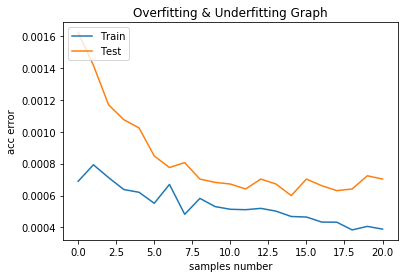

In [7]:
'''
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
'''

# Plot training & validation loss values
plt.plot(scores['train'])
plt.plot(scores['valid'])
plt.title('Overfitting & Underfitting Graph')
plt.ylabel('acc error')
plt.xlabel('samples number')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# ROC Curve 